In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jjuoda_dl4 import utils

FIGURES_PATH = utils.BASE_FIGURES_DIR / "eda-fake--news-content-detection"
sns.set_context("talk")

In [41]:
fake_news_content_detection_df = pd.read_csv(
    utils.BASE_DATA_DIR / "raw/Fake News Content Detection/train.csv"
)
fake_news_content_detection_df.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


In [42]:
# labels dict from kaggle competition

labels_dict = {
    0: "Barely-True",
    1: "False",
    2: "Half-True",
    3: "Mostly-True",
    4: "Not-Known",
    5: "True",
}

fake_news_content_detection_df["Labels"].replace(labels_dict, inplace=True)

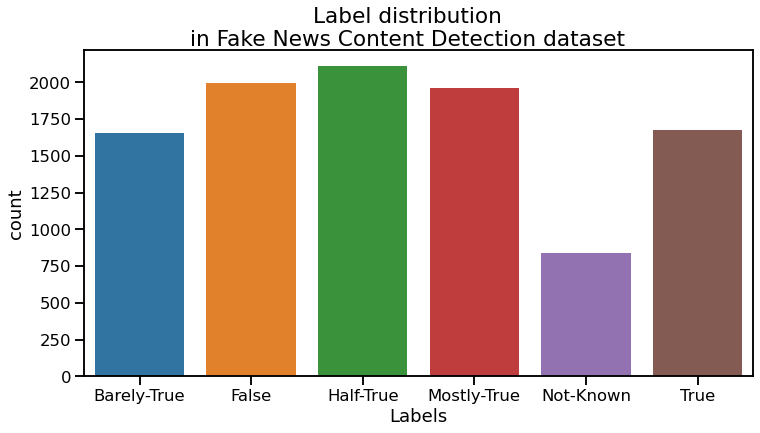

In [43]:
plt.figure(figsize=(12, 6))

plt.suptitle("Label distribution\nin Fake News Content Detection dataset")

sns.countplot(
    data=fake_news_content_detection_df, x="Labels", order=list(labels_dict.values())
)
plt.savefig(FIGURES_PATH / "label_distribution.png")

Very interesting mapping of labels. I'd consider False to be more "fake" than Barely-True label and give swap their labels, mapping is what it is.

We don't have title and all my models assume that we have title. I guess I'll take first sentence as title.

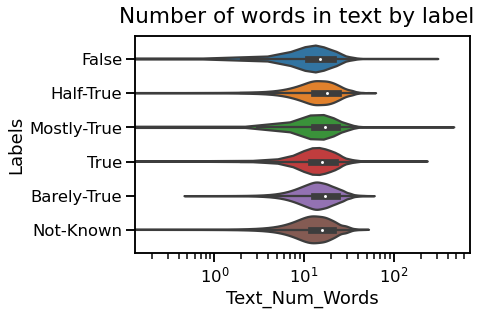

In [44]:
fake_news_content_detection_df["Text_Num_Words"] = (
    fake_news_content_detection_df["Text"].str.split().str.len()
)

plt.suptitle("Number of words in text by label")

ax = sns.violinplot(
    data=fake_news_content_detection_df, x="Text_Num_Words", bins=100, y="Labels"
)

plt.semilogx()
plt.savefig(FIGURES_PATH / "text_num_words_by_label.png")

In [45]:
fake_news_content_detection_df["Text_Num_Words"].describe()

count    10240.000000
mean        18.010059
std          9.658572
min          2.000000
25%         12.000000
50%         17.000000
75%         22.000000
max        467.000000
Name: Text_Num_Words, dtype: float64

My eyes tell me that if we exclude outliers, each text length:
1. is distributed more or less the same across all texts
1. is much shorter than what we have trained our model with.

Second point might be a problem for my model, which is perfect - I'll get to know if it generalizes to shorter pieces.

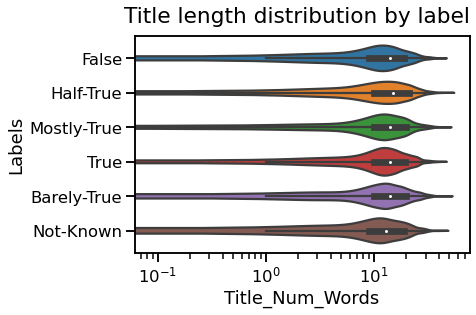

In [46]:
def take_first_sentence(texts: pd.Series):
    return texts.str.split(r"\.|\?|!", n=1, expand=True)[0]


fake_news_content_detection_df["Title"] = take_first_sentence(
    fake_news_content_detection_df["Text"]
)
fake_news_content_detection_df["Title_Num_Words"] = (
    fake_news_content_detection_df["Title"].str.split().str.len()
)

plt.suptitle("Title length distribution by label")

ax = sns.violinplot(
    data=fake_news_content_detection_df, x="Title_Num_Words", bins=100, y="Labels"
)

plt.semilogx();

In [47]:
(
    fake_news_content_detection_df["Title_Num_Words"]
    == fake_news_content_detection_df["Text_Num_Words"]
).mean()

0.7671875

Three quarters of my pieces are just a single sentence.

In [48]:
# I always use lowercase case column names in other parts of this project so rename it here

fake_news_content_detection_df.columns = [
    col.lower() for col in fake_news_content_detection_df.columns
]

In [49]:
# Provide same label I use in the rest of the project; it's just arbitrary decision without even taking a closer look into data tho

fake_news_content_detection_df["is_fake"] = pd.NA
fake_news_content_detection_df.loc[
    fake_news_content_detection_df["labels"] == "True", "is_fake"
] = False
fake_news_content_detection_df.loc[
    fake_news_content_detection_df["labels"] == "Mostly-True", "is_fake"
] = False
fake_news_content_detection_df.loc[
    fake_news_content_detection_df["labels"] == "Barely-True", "is_fake"
] = True
fake_news_content_detection_df.loc[
    fake_news_content_detection_df["labels"] == "False", "is_fake"
] = True

/home/julius/.conda/envs/jjuoda-DL.4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_fake', ylabel='count'>

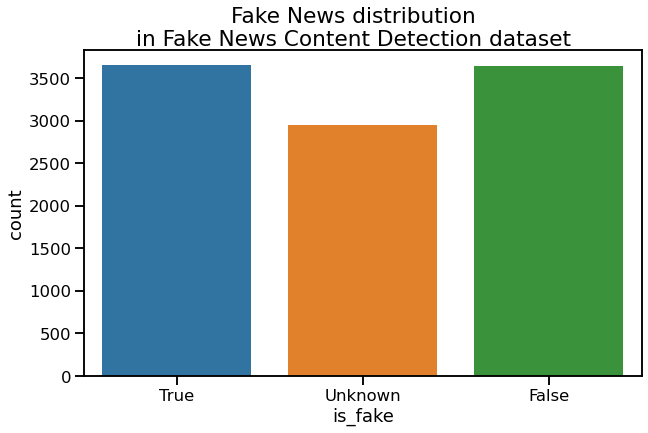

In [50]:
plt.figure(figsize=(10, 6))

plt.suptitle("Fake News distribution\nin Fake News Content Detection dataset")

sns.countplot(fake_news_content_detection_df.is_fake.fillna("Unknown"))

This actually looks very reasonable.

In [51]:
fake_news_content_detection_df.to_csv(
    utils.BASE_DATA_DIR / "final/fake_news_content_detection.csv", index=False
)